In [45]:
!pip install yfinance
!pip install pmdarima

[*********************100%%**********************]  1 of 1 completed


 Analyzing AAPL...



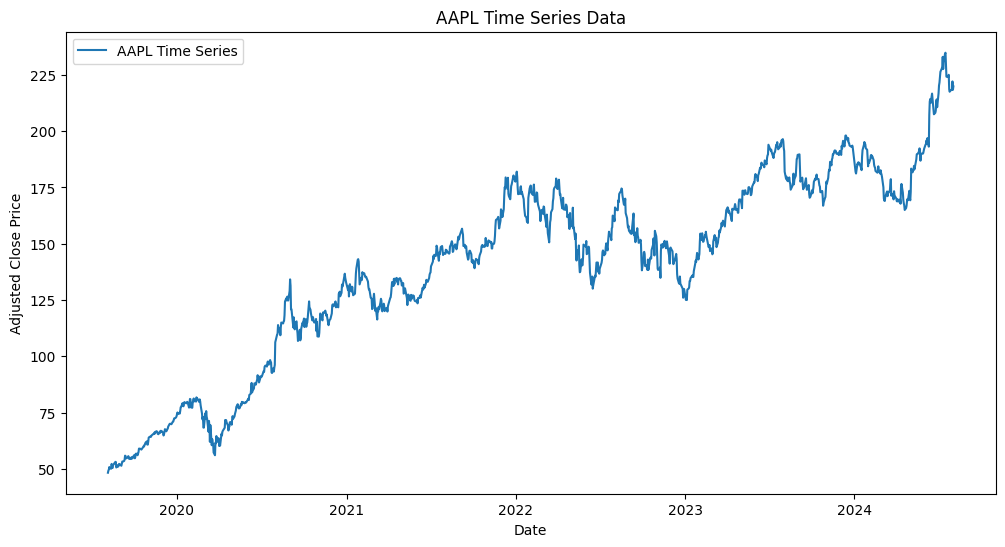

In [46]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

stock = 'AAPL'

data = yf.download(stock, start='2019-08-05', end='2024-08-05')['Close']

# Ensure the index is a datetime index
data.index = pd.to_datetime(data.index)

print(f"\n Analyzing {stock}...\n")

# Plotting  the time series data
plt.figure(figsize=(12, 6))
plt.plot(data, label=f'{stock} Time Series')
plt.title(f'{stock} Time Series Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

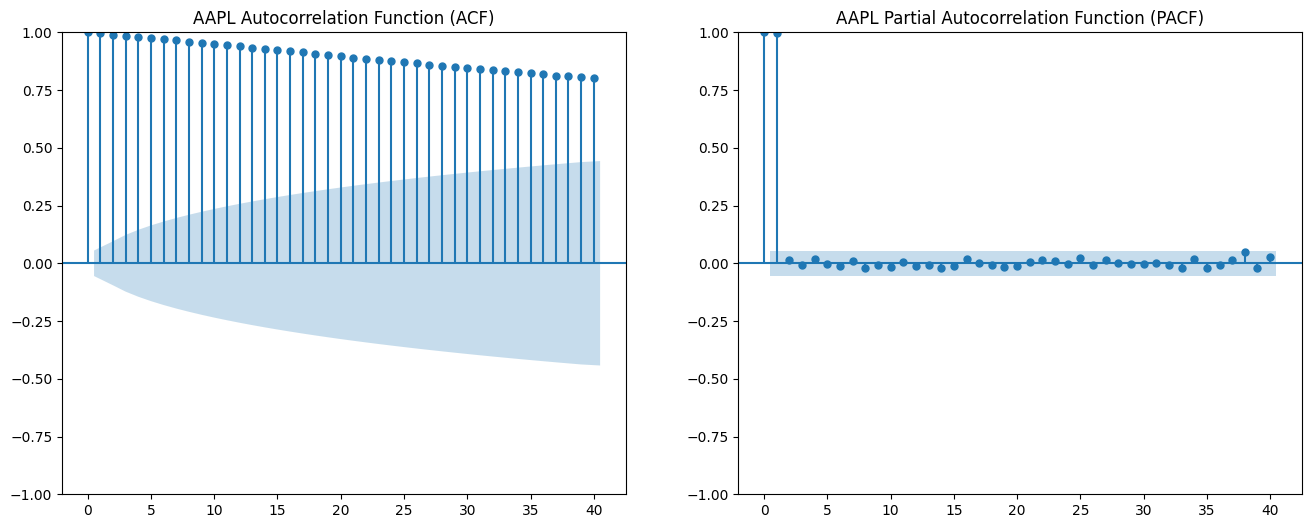

In [47]:
# Plotting the ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data.dropna(), lags=40, ax=axes[0])
axes[0].set_title(f'{stock} Autocorrelation Function (ACF)')
plot_pacf(data.dropna(), lags=40, ax=axes[1])
axes[1].set_title(f'{stock} Partial Autocorrelation Function (PACF)')
plt.show()

In [48]:
# The Augmented Dickey-Fuller (ADF) test
result = adfuller(data.dropna())
print(f'ADF Statistic for {stock}: %f' % result[0])
print(f'p-value for {stock}: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF Statistic for AAPL: -1.353933
p-value for AAPL: 0.604151
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [49]:
# Split the data into training and test sets
train_size = int(len(data) * 0.3)
train, test = data[:train_size], data[train_size:]

# Use auto_arima to find the best ARIMA model
auto_arima_model = pm.auto_arima(train,
                                 start_p=0, start_q=0,
                                 test='adf',  # use adftest to find optimal 'd'
                                 max_p=5, max_q=5,
                                 seasonal=False,
                                 d=None,  # You can set this to 'None' to let auto_arima find the best value
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1691.621, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1686.111, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1686.716, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1693.361, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1687.563, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1687.611, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1689.547, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1688.981, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.464 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  377
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -840.055
Date:                Thu, 22 Aug 2024   AIC                           1686.111
Time:                        23:03:4

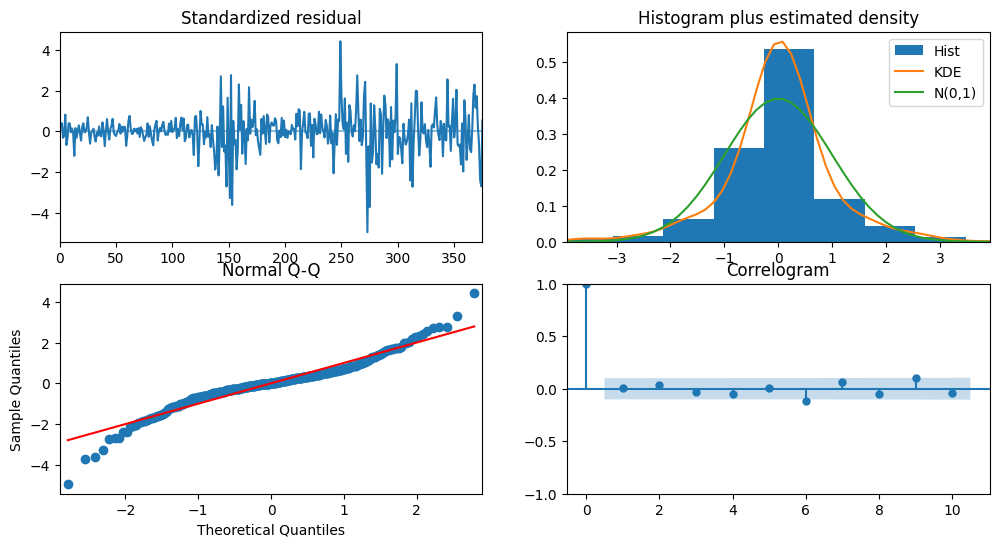

In [50]:
auto_arima_model.plot_diagnostics(figsize=(12, 6))
plt.show()

In [51]:
train_predict = auto_arima_model.predict(n_periods=len(train))
test_predict_A = auto_arima_model.predict(n_periods=len(test))

/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next vers

In [52]:
import math
print(math.sqrt(mean_squared_error(train,train_predict)))
print(math.sqrt(mean_squared_error(test,test_predict_A)))

89.70484283609817
83.3067382119317


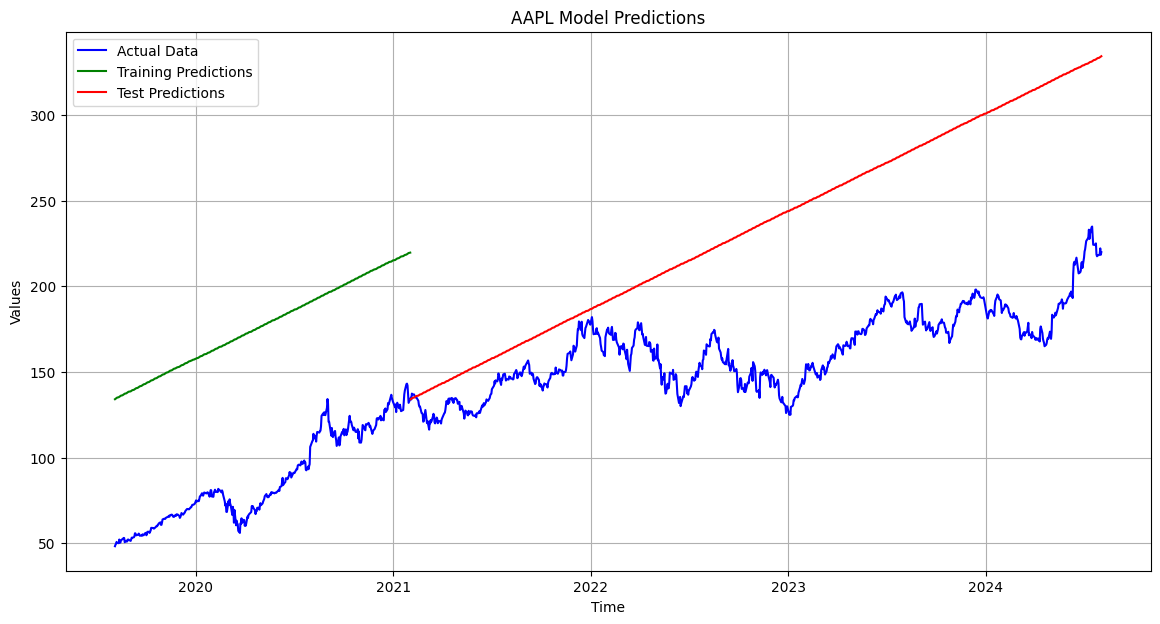

In [60]:
import pandas as pd
import matplotlib.pyplot as plt


train_dates = data.index[:train_size]
test_dates = data.index[train_size:]
plt.figure(figsize=(14, 7))
plt.plot(data.index, data, label='Actual Data', color='blue')
plt.plot(train_dates, train_predict, label='Training Predictions', color='green')
plt.plot(test_dates, test_predict_A, label='Test Predictions', color='red')
plt.title(f'{stock} Model Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

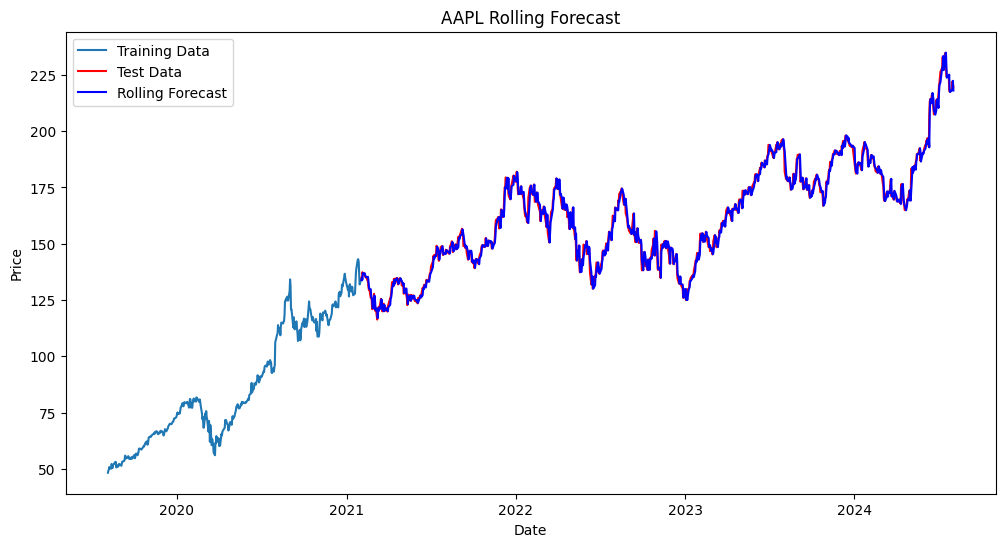

Root Mean Squared Error (RMSE): 2.7102


In [61]:
# Rolling forecasts
history = list(train)
predictions = []

for i in range(len(test)):
    model = ARIMA(history, order=auto_arima_model.order)  # Use the best order found by auto_arima
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[i])
    history.pop(0)

# Convert predictions to a pandas Series
test_predict = pd.Series(predictions, index=test.index)

# Plot rolling forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='red')
plt.plot(test_predict.index, test_predict, label='Rolling Forecast', color='blue')
plt.title(f'{stock} Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Recalculate the evaluation metrics for rolling forecasts
rmse_roll = np.sqrt(mean_squared_error(test, test_predict))

print(f"Root Mean Squared Error (RMSE): {rmse_roll:.4f}")


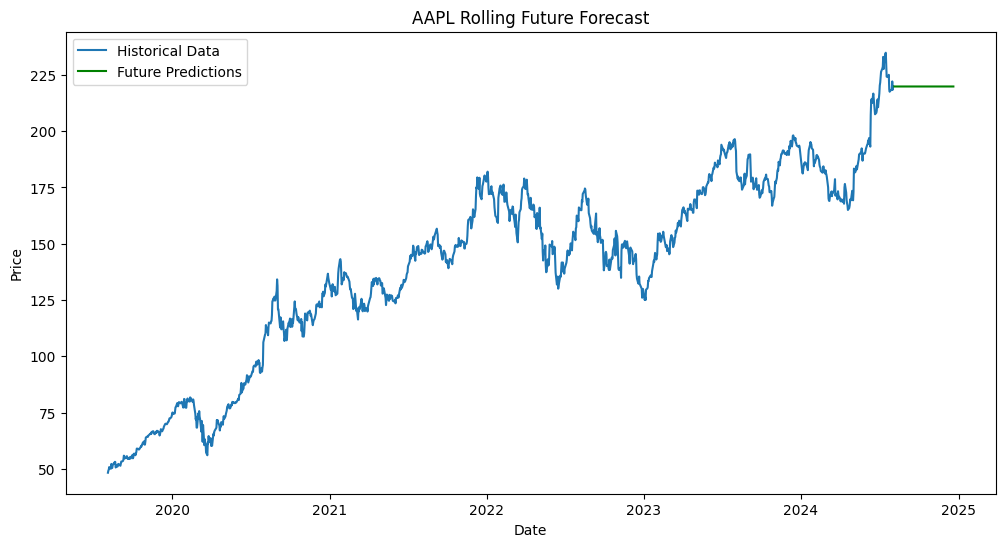

In [55]:
history_2 = list(data)
n_future = 100  # Number of future periods to predict
future_predictions = []
 
for i in range(n_future):
    model = ARIMA(history_2, order=auto_arima_model.order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    future_predictions.append(yhat)
    history_2.append(yhat)
    history_2.pop(0)

# Create a future index for the predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='B')

# Convert future predictions to a pandas Series
future_predictions_series = pd.Series(future_predictions, index=future_dates)

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Historical Data')
plt.plot(future_predictions_series.index, future_predictions_series, label='Future Predictions', color='green')
plt.title(f'{stock} Rolling Future Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shivamarora/Desktop/DSProject/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


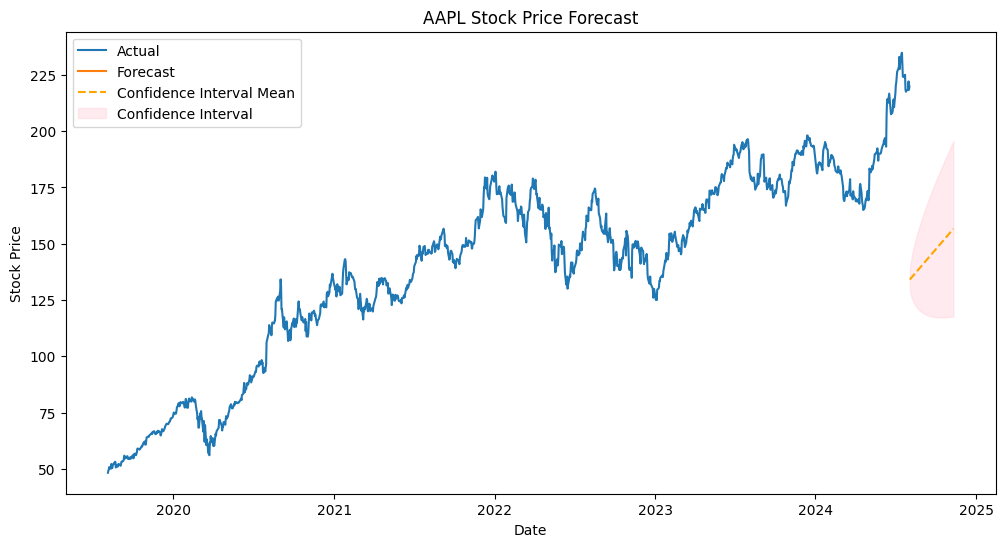

In [56]:
from pandas.tseries.offsets import DateOffset

n_periods = 100
forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Create future dates for the forecast period
future_dates = [data.index[-1] + DateOffset(days=x) for x in range(1, n_periods + 1)]
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Calculate the mean of the confidence interval
conf_mean = (conf_int[:, 0] + conf_int[:, 1]) / 2
mean_df = pd.DataFrame(conf_mean, index=future_dates, columns=['Conf_Mean'])

# Concatenate the original data with the forecast data
future_df = pd.concat([data, forecast_df])

# Plot the original data, forecast, and mean of the confidence interval
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df, label='Original Data and Forecast')
plt.plot(mean_df.index, mean_df, linestyle='--', color='orange', label='Confidence Interval Mean')
plt.fill_between(forecast_df.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend(['Actual', 'Forecast', 'Confidence Interval Mean', 'Confidence Interval'])
plt.title(f'{stock} Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
